In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 'full' # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1.0_1024_full____2020_08_09_12_36_00_056770_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [9]:
weight_decay = 1e-4
# https://github.com/RaptorMai/Cifar10-CNN-Keras/blob/master/Cifar_better.ipynb
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=dims))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(Dropout(0.9))
model.add(Dense(512))
model.add(Dropout(0.9))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [21]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

In [22]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [23]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [24]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [26]:
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=250,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/250
313/313 [==============================] - 3s 11ms/step - loss: 17.6068 - accuracy: 0.1126 - val_loss: 2.4360 - val_accuracy: 0.1016
Epoch 2/250
313/313 [==============================] - 3s 10ms/step - loss: 5.9526 - accuracy: 0.1144 - val_loss: 2.4836 - val_accuracy: 0.1159
Epoch 3/250
313/313 [==============================] - 3s 9ms/step - loss: 4.5749 - accuracy: 0.1186 - val_loss: 2.7855 - val_accuracy: 0.1136
Epoch 4/250
313/313 [==============================] - 3s 10ms/step - loss: 4.1230 - accuracy: 0.1161 - val_loss: 3.1053 - val_accuracy: 0.1228
Epoch 5/250
313/313 [==============================] - 5s 15ms/step - loss: 3.9518 - accuracy: 0.1156 - val_loss: 2.8958 - val_accuracy: 0.1263
Epoch 6/250
313/313 [==============================] - 5s 15ms/step - loss: 3.7776 - accuracy: 0.1225 - val_loss: 2.7754 - val_accuracy: 0.1588
Epoch 7/250
313/313 [==============================] - 5s 15ms/step - loss: 3.6712 - accuracy: 0.1271 - val_loss: 2.7794 - val_accuracy:

313/313 [==============================] - 3s 9ms/step - loss: 2.3434 - accuracy: 0.4825 - val_loss: 2.0126 - val_accuracy: 0.5500
Epoch 58/250
313/313 [==============================] - 3s 10ms/step - loss: 2.3167 - accuracy: 0.4879 - val_loss: 2.1455 - val_accuracy: 0.5501
Epoch 59/250
313/313 [==============================] - 3s 10ms/step - loss: 2.3534 - accuracy: 0.4915 - val_loss: 2.1285 - val_accuracy: 0.5432
Epoch 60/250
313/313 [==============================] - 3s 10ms/step - loss: 2.3064 - accuracy: 0.4964 - val_loss: 2.1046 - val_accuracy: 0.5591
Epoch 61/250
313/313 [==============================] - 3s 10ms/step - loss: 2.3634 - accuracy: 0.4974 - val_loss: 1.9083 - val_accuracy: 0.5478
Epoch 62/250
313/313 [==============================] - 4s 14ms/step - loss: 2.3025 - accuracy: 0.5014 - val_loss: 1.9907 - val_accuracy: 0.5468
Epoch 63/250
313/313 [==============================] - 5s 14ms/step - loss: 2.2732 - accuracy: 0.5121 - val_loss: 2.2863 - val_accuracy: 0.5645

313/313 [==============================] - 3s 10ms/step - loss: 1.8661 - accuracy: 0.6548 - val_loss: 1.6811 - val_accuracy: 0.6521
Epoch 114/250
313/313 [==============================] - 3s 9ms/step - loss: 1.8884 - accuracy: 0.6539 - val_loss: 1.7612 - val_accuracy: 0.6880
Epoch 115/250
313/313 [==============================] - 3s 9ms/step - loss: 1.8835 - accuracy: 0.6557 - val_loss: 1.6279 - val_accuracy: 0.6885
Epoch 116/250
313/313 [==============================] - 3s 9ms/step - loss: 1.8386 - accuracy: 0.6561 - val_loss: 1.5675 - val_accuracy: 0.6858
Epoch 117/250
313/313 [==============================] - 3s 10ms/step - loss: 1.8831 - accuracy: 0.6579 - val_loss: 1.7183 - val_accuracy: 0.6724
Epoch 118/250
313/313 [==============================] - 3s 10ms/step - loss: 1.8491 - accuracy: 0.6604 - val_loss: 1.8246 - val_accuracy: 0.6836
Epoch 119/250
313/313 [==============================] - 3s 9ms/step - loss: 1.8216 - accuracy: 0.6660 - val_loss: 1.7586 - val_accuracy: 0.6

313/313 [==============================] - 3s 10ms/step - loss: 1.5812 - accuracy: 0.7354 - val_loss: 1.4418 - val_accuracy: 0.7459
Epoch 170/250
313/313 [==============================] - 3s 10ms/step - loss: 1.5695 - accuracy: 0.7375 - val_loss: 1.5002 - val_accuracy: 0.7433
Epoch 171/250
313/313 [==============================] - 3s 10ms/step - loss: 1.5624 - accuracy: 0.7397 - val_loss: 1.4973 - val_accuracy: 0.7417
Epoch 172/250
313/313 [==============================] - 3s 10ms/step - loss: 1.5628 - accuracy: 0.7390 - val_loss: 1.4960 - val_accuracy: 0.7396
Epoch 173/250
313/313 [==============================] - 3s 10ms/step - loss: 1.5717 - accuracy: 0.7413 - val_loss: 1.5454 - val_accuracy: 0.7334
Epoch 174/250
313/313 [==============================] - 3s 10ms/step - loss: 1.5469 - accuracy: 0.7445 - val_loss: 1.4813 - val_accuracy: 0.7302
Epoch 175/250
313/313 [==============================] - 3s 10ms/step - loss: 1.5486 - accuracy: 0.7442 - val_loss: 1.4474 - val_accuracy:

313/313 [==============================] - 5s 15ms/step - loss: 1.3049 - accuracy: 0.8105 - val_loss: 1.3320 - val_accuracy: 0.7833
Epoch 226/250
313/313 [==============================] - 4s 12ms/step - loss: 1.3033 - accuracy: 0.8108 - val_loss: 1.3188 - val_accuracy: 0.7899
Epoch 227/250
313/313 [==============================] - 3s 10ms/step - loss: 1.2976 - accuracy: 0.8138 - val_loss: 1.3252 - val_accuracy: 0.7862
Epoch 228/250
313/313 [==============================] - 3s 9ms/step - loss: 1.2972 - accuracy: 0.8128 - val_loss: 1.3241 - val_accuracy: 0.7874
Epoch 229/250
313/313 [==============================] - 3s 10ms/step - loss: 1.2938 - accuracy: 0.8166 - val_loss: 1.3290 - val_accuracy: 0.7828
Epoch 230/250
313/313 [==============================] - 3s 10ms/step - loss: 1.2945 - accuracy: 0.8145 - val_loss: 1.3273 - val_accuracy: 0.7848
Epoch 231/250
313/313 [==============================] - 3s 10ms/step - loss: 1.2909 - accuracy: 0.8192 - val_loss: 1.3126 - val_accuracy: 

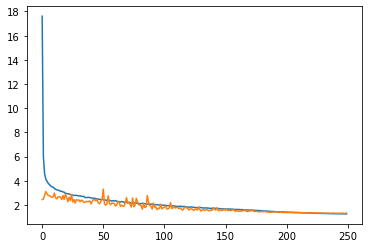

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

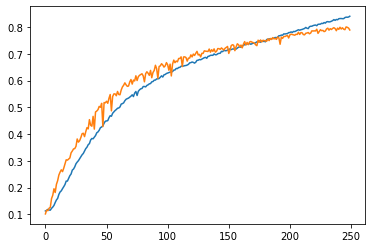

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [30]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('dense_1').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 4, 4, 512)

In [34]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 14:26:51 2020 Finding Nearest Neighbors
Sun Aug  9 14:26:52 2020 Building RP forest with 15 trees
Sun Aug  9 14:26:56 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 14:27:05 2020 Finished Nearest Neighbor Search
Sun Aug  9 14:27:07 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 14:27:49 2020 Finished embedding


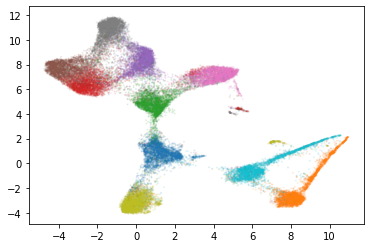

In [36]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 17:20:35 2020 Finding Nearest Neighbors
Sun Aug  9 17:20:35 2020 Building RP forest with 10 trees
Sun Aug  9 17:20:36 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Sun Aug  9 17:20:38 2020 Finished Nearest Neighbor Search
Sun Aug  9 17:20:38 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  9 17:21:09 2020 Finished embedding


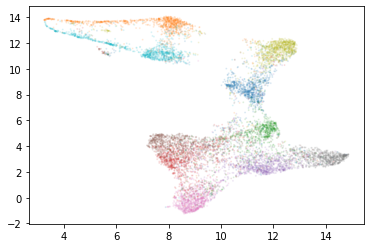

In [37]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

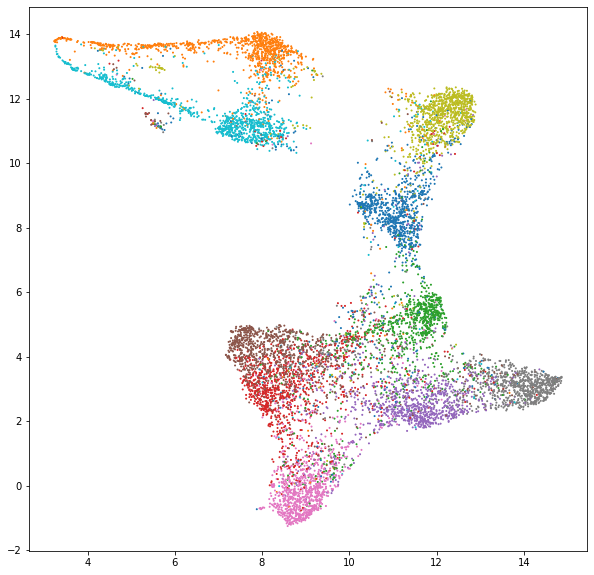

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [39]:
predictions = model.predict(X_valid)

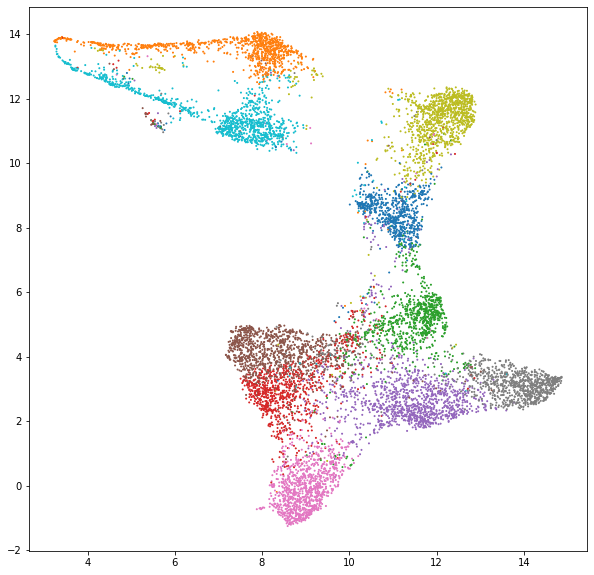

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)